Consider the following example which does basic dupin detection using a freud generator:
Now, lets try and write the same generator as a custom generator:
Instead of simply reproducing the same results we are at liberty now to modify it to our
wishes


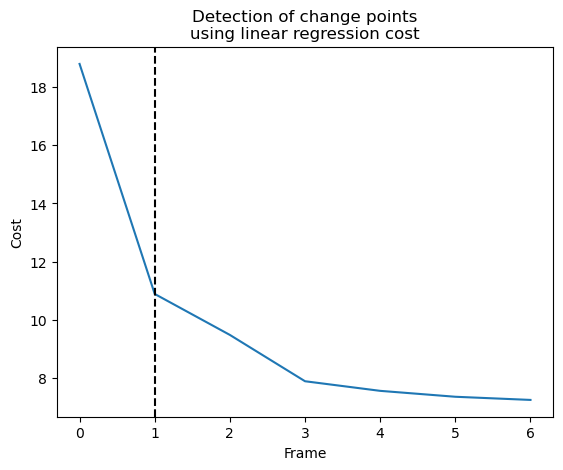

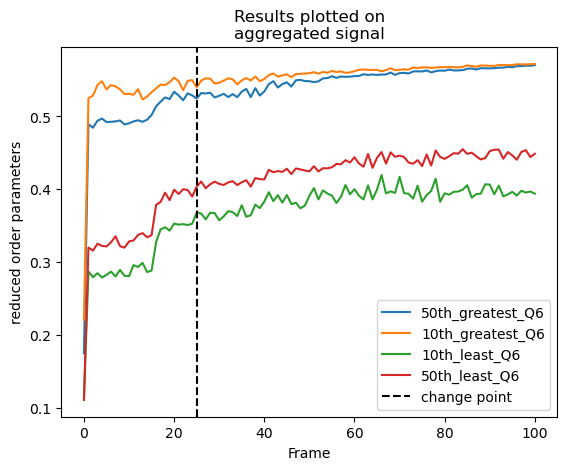

In [15]:
import dupin as du
import gsd.hoomd
import freud
import matplotlib.pyplot as plt
import ruptures as rpt

ls = 6
FILENAME = "../data/lj-sim.gsd"
steinhardt = freud.order.Steinhardt(l=ls)
nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
pipeline = du.data.freud.FreudDescriptor(
    compute=steinhardt, attrs={"particle_order": f"Q{ls}"}
).pipe(du.data.reduce.NthGreatest((10, -10, -50, 50)))
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)  # ,logger)
with gsd.hoomd.open(FILENAME, "r") as traj:
    for frame in traj:
        signal_aggregator.accumulate(frame, nlist_kwargs)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
# plot as heatmap
# y axis values should be binz - use vmin and vmax to set the range
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

Now lets transcribe the above example with a custom generator


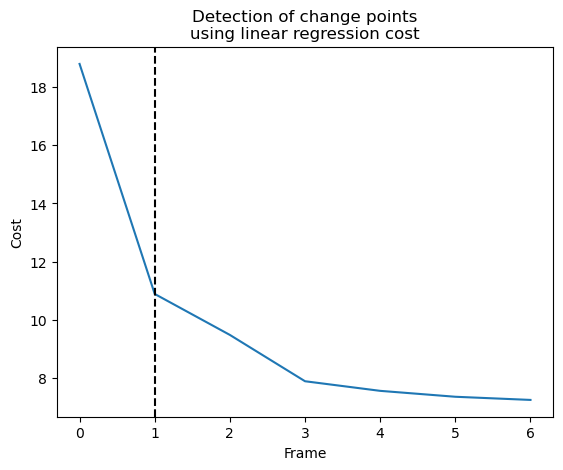

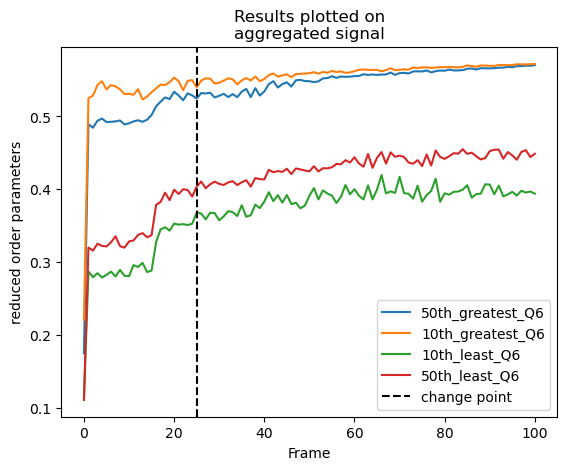

In [9]:
import dupin as du
import gsd.hoomd
import freud
import matplotlib.pyplot as plt
import ruptures as rpt

ls = 6
FILENAME = "../data/lj-sim.gsd"


def steinhardt_custom_generator(system):
    steinhardt = freud.order.Steinhardt(l=ls)
    nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
    steinhardt.compute(system, neighbors=nlist_kwargs)
    return {f"Q{ls}": steinhardt.particle_order}


pipeline = du.data.base.CustomGenerator(steinhardt_custom_generator).pipe(
    du.data.reduce.NthGreatest((10, -10, -50, 50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)  # ,logger)
with gsd.hoomd.open(FILENAME, "r") as traj:
    for frame in traj:
        signal_aggregator.accumulate(frame)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
# plot as heatmap
# y axis values should be binz - use vmin and vmax to set the range
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

They are exactly the same! Now lets try computing two different ls for steinhardt

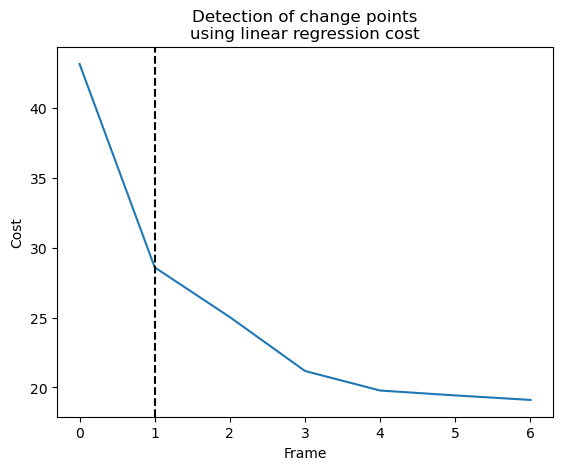

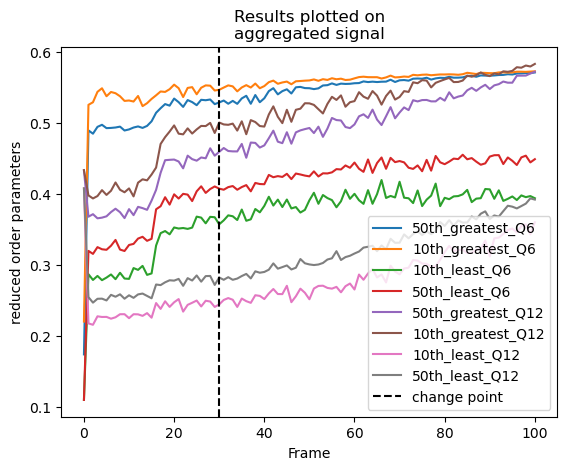

In [14]:
import dupin as du
import gsd.hoomd
import freud
import matplotlib.pyplot as plt
import ruptures as rpt

# Usage example
ls = [6, 12]
FILENAME = "../data/lj-sim.gsd"

steinhardt = freud.order.Steinhardt(l=ls)
nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}


def steinhardt_custom_generator(system):
    steinhardt = freud.order.Steinhardt(l=ls)
    nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
    steinhardt.compute(system, neighbors=nlist_kwargs)
    keys = [f"Q{l}" for l in ls]
    properties_dict = {}
    for i, key in enumerate(keys):
        properties_dict[key] = steinhardt.particle_order.T[i]
    return properties_dict


pipeline = du.data.base.CustomGenerator(steinhardt_custom_generator).pipe(
    du.data.reduce.NthGreatest((10, -10, -50, 50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)  # ,logger)
with gsd.hoomd.open(FILENAME, "r") as traj:
    for frame in traj:
        signal_aggregator.accumulate(frame)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
# plot as heatmap
# y axis values should be binz - use vmin and vmax to set the range
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

Now lets do a more complicated example: minkowski!

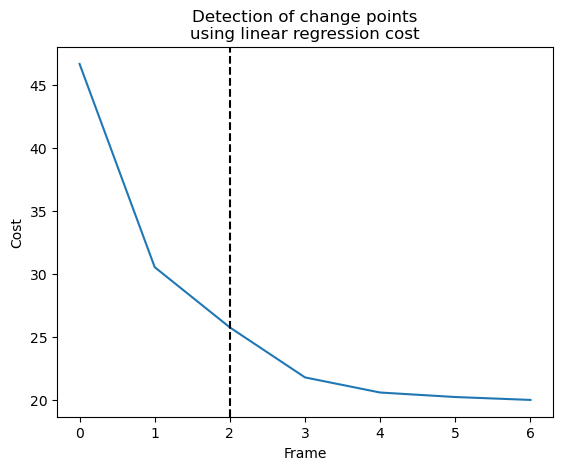

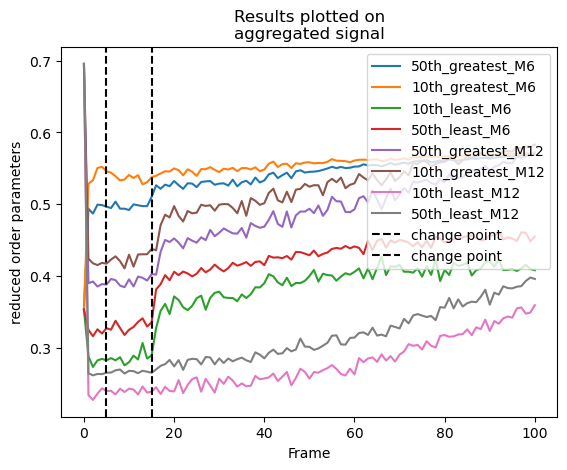

In [13]:
import dupin as du
import gsd.hoomd
import freud
import matplotlib.pyplot as plt
import ruptures as rpt

ls = [6, 12]
FILENAME = "../data/lj-sim.gsd"

# custom generator function
def minkowski_generator(system):
    # compute voronoi neighbors and get nlist
    vor = freud.locality.Voronoi()
    vor.compute(system)
    nlist = vor.nlist
    # compute steinhardt
    steinhardt = freud.order.Steinhardt(l=ls, weighted=True)
    steinhardt.compute(system, neighbors=nlist)
    keys = [f"M{l}" for l in ls]
    properties_dict = {}
    for i, keys in enumerate(keys):
        properties_dict[keys] = steinhardt.particle_order.T[i]
    return properties_dict


pipeline = du.data.base.CustomGenerator(minkowski_generator).pipe(
    du.data.reduce.NthGreatest((10, -10, -50, 50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)  # ,logger)
with gsd.hoomd.open(FILENAME, "r") as traj:
    for frame in traj:
        signal_aggregator.accumulate(frame)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
# plot as heatmap
# y axis values should be binz - use vmin and vmax to set the range
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend(loc="upper right")
plt.show()